In [7]:
###IMPORTS 
import logging
from collections import OrderedDict
import datetime
import torch
from torch import nn
import torchvision
from torchvision import transforms
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

import inversefed

In [8]:
### EARLY STOPPING CLASS FOR FASTER RECONSTRUCTION
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    Code inspired by https://github.com/Bjarten/early-stopping-pytorch 26.03.2021
    """
    def __init__(self, patience=7, delta=0, metric='loss', subject_to='min', verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            metric (str): string of the metric we are looking at in our history
            subject_to (str): Defines whether the metric is subject to minimazation or maximization; 'min' or 'max' (defaut or when misspelled: 'min')
            verbose (bool): If True, logs a message for each validation loss improvement.
                            Default: False
        """
        self.patience = patience
        self.metric = metric
        self.subject_to = subject_to
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.stop = False
        self.improved = False
        self.delta = delta

    def get_state(self):
        return self.__dict__

    def set_state(self, state_dict):
        self.__dict__ = state_dict

    def __call__(self, metric):
        if self.subject_to == 'max':
            score = -metric
        else:
            score = metric

        if self.best_score is None:
            self.improved = True
            self.best_score = score
        elif score >= self.best_score + self.delta:
            self.improved = False
            self.counter += 1
            if self.verbose:
                logging.info(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.improved = True
            self.best_score = score
            self.counter = 0

In [9]:
### MSE Metric Class
class Metric:
    def __init__(self):
        self.metric_fn = None
    def __call__(self, prediction, truth):
        if self.metric_fn == None:
            raise  NotImplementedError()
        else:
            return self.metric_fn(prediction, truth)
            
class MSE(Metric):
    def __init__(self, reduce=True):
        if reduce:
            self.metric_fn = torch.nn.MSELoss(size_average=None, reduction='mean')
        else:
            self.metric_fn = self.mse
        self.format = '.6f'
        self.reduce = reduce
        self.name = 'MSE'
        self.target = 'features'

    def mse(self, x, y):
        if not self.reduce:
            mse_fn = torch.nn.MSELoss(size_average=None, reduction='none')
            value = mse_fn(x, y)
            for _ in range(len(value.shape)-1):
                value = value.mean(dim=-1)
            return value
        else:
            print('You shouldn\'t be here.')

In [10]:
### DEFINE SOME BASIC FUNCTIONS
def system_startup(args=None, defs=None):
    """Set Logging"""
    rootLogger = logging.getLogger()
    logFormatter = logging.Formatter('%(asctime)s:[%(levelname)s][%(filename)s][%(funcName)s] %(message)s')
    consoleHandler = logging.StreamHandler(sys.stdout)
    consoleHandler.setFormatter(logFormatter)
    rootLogger.addHandler(consoleHandler)
    rootLogger.setLevel(logging.INFO)

    """Log useful system information."""
    # Choose GPU device and print status information:
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    #torch.multiprocessing.set_start_method('spawn')
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    logging.info('Currently evaluating -------------------------------:')
    logging.info(datetime.datetime.now().strftime("%A, %d. %B %Y %I:%M%p"))
    logging.info(f'CPUs: {torch.get_num_threads()}, GPUs: {torch.cuda.device_count()}.')
    if args is not None:
        logging.info(args)
    if defs is not None:
        logging.info(repr(defs))
    if torch.cuda.is_available():
        logging.info(f'GPU : {torch.cuda.get_device_name(device=device)}')
    torch.autograd.set_detect_anomaly(True)
    logging.info('Activating torch.autograd anomaly detection')
    return device
    
def build_cifar10(batch_size = 64, datapath='./data/', train_transformations = transforms.ToTensor(), val_transformations = transforms.ToTensor()):
    trn_set = torchvision.datasets.CIFAR10(root=datapath, train=True, download=True, transform=train_transformations)
    tst_set = torchvision.datasets.CIFAR10(root=datapath, train=False, download=True, transform=val_transformations)
    trn_loader = torch.utils.data.DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=True)
    tst_loader = torch.utils.data.DataLoader(tst_set, batch_size=batch_size, shuffle=False, drop_last=False)
    return trn_loader, tst_loader

def get_gradient(model, input_data, gt_labels, loss_fn, train_mode, device):
    print('Generatig gradient from victim data...')
    if train_mode:
        model.train()
    else:
        model.eval()

    model.zero_grad()
    target_loss = loss_fn(model(input_data), gt_labels)
    gradient = torch.autograd.grad(target_loss, model.parameters(), allow_unused=True)
    #return gradient
    gradient = [grad.detach() for grad in gradient if type(grad) == torch.Tensor]

    return gradient

def gradient_inversion(gradient, labels, model, data_shape, dm, ds, device):
    print('Performing a Gradientinversion attack.')
    #build inversefed library specific config for the reconstruction attack
    c = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=7000,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss',
              loss_fn = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean'), #(Loss fn the model was trianed with)
              early_stopper = EarlyStopping(1000, 0, 'ReconstructionLoss', 'min', False)
              )
    rec_machine = inversefed.GradientReconstructor(model, (dm, ds), c, num_images=batch_size)
    output, stats = rec_machine.reconstruct(gradient, labels, img_shape=data_shape)

    return output, stats['opt']


def match_reconstructions(images, reconstructions):
    cost_matrix = get_similarity_cost_matrix(images, reconstructions)
    rec_idx = linear_sum_assignment(cost_matrix, maximize=True)[1]
    return reconstructions[rec_idx].detach().clone()


def get_similarity_cost_matrix(images, reconstructions):
    m = MSE(False)
    cost_matrix = []
    for img in images:
        i, r = torch.broadcast_tensors(img, reconstructions)
        current_metric = m(i, r)
        cost_matrix.append(np.array(current_metric).astype(float))
    return np.array(cost_matrix)

def show_single_img(img):
    plt.imshow(img.permute(1, 2, 0).cpu());
    plt.axis('off')
    plt.show()
    plt.close()

In [11]:
#Get Hardware
device = system_startup()

#Prep dataset
trn_loader, tst_loader = build_cifar10(batch_size=16)
for i, l in trn_loader:
    images = i
    labels = l
    break
images = images.to(device)
labels = labels.to(device)
batch_size = images.shape[0]
data_shape = (3,32,32)
num_classes = 10

cifar10_mean = [0.4914672374725342, 0.4822617471218109, 0.4467701315879822]
cifar10_std = [0.24703224003314972, 0.24348513782024384, 0.26158785820007324]
dm = torch.as_tensor(cifar10_mean)[:, None, None]
ds = torch.as_tensor(cifar10_std)[:, None, None]

#Get model and Loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
model = nn.Sequential(OrderedDict([
            ('flatten', nn.Flatten()),
            ('linear0', nn.Linear(np.prod(data_shape), 1024)),
            ('relu0', nn.ReLU()),
            ('linear1', nn.Linear(1024, 1024)),
            ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(1024, num_classes))]))

gradient = get_gradient(model, images, labels, loss_fn, True, device)
output, best_loss = gradient_inversion(gradient, labels, model, data_shape, dm, ds, device)



2021-05-10 12:08:47,492:[INFO][<ipython-input-10-e21574ee2f77>][system_startup] Currently evaluating -------------------------------:
2021-05-10 12:08:47,493:[INFO][<ipython-input-10-e21574ee2f77>][system_startup] Monday, 10. May 2021 12:08PM
2021-05-10 12:08:47,494:[INFO][<ipython-input-10-e21574ee2f77>][system_startup] CPUs: 10, GPUs: 1.
2021-05-10 12:08:47,496:[INFO][<ipython-input-10-e21574ee2f77>][system_startup] GPU : TITAN Xp
2021-05-10 12:08:47,497:[INFO][<ipython-input-10-e21574ee2f77>][system_startup] Activating torch.autograd anomaly detection
Files already downloaded and verified
Files already downloaded and verified
Generatig gradient from victim data...
Performing a Gradientinversion attack.
2021-05-10 12:08:51,183:[INFO][reconstruction_algorithms.py][_run_trial] It: 0. Rec. loss: 0.8062.
2021-05-10 12:09:32,720:[INFO][reconstruction_algorithms.py][_run_trial] It: 500. Rec. loss: 0.0536.
2021-05-10 12:10:13,783:[INFO][reconstruction_algorithms.py][_run_trial] It: 1000. Re

In [12]:
images = images.detach().clone().cpu()
output = output.detach().clone().cpu()

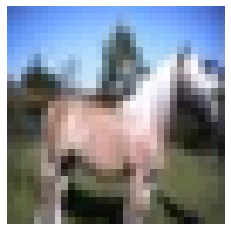

2021-05-10 12:16:22,595:[WARNING][image.py][set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


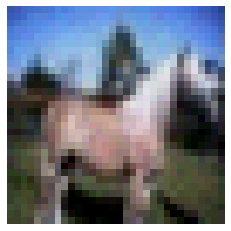

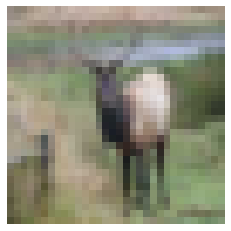

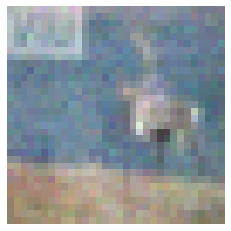

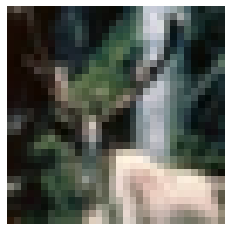

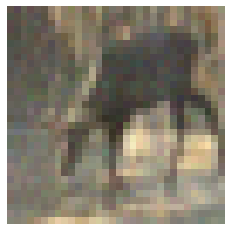

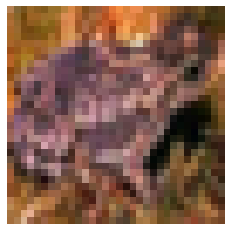

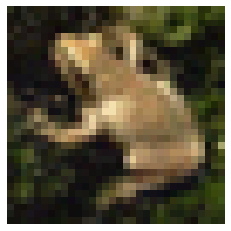

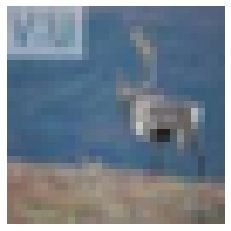

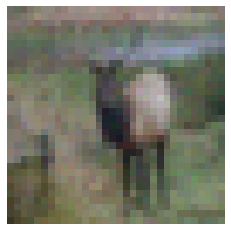

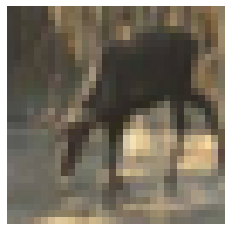

2021-05-10 12:16:23,375:[WARNING][image.py][set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


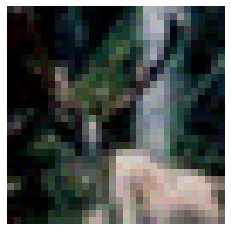

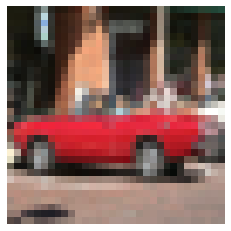

2021-05-10 12:16:23,521:[WARNING][image.py][set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


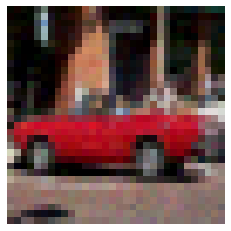

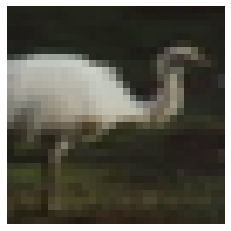

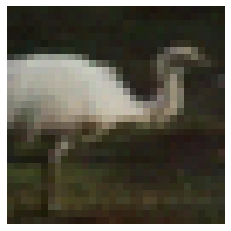

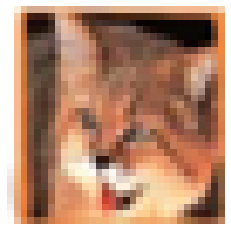

2021-05-10 12:16:23,826:[WARNING][image.py][set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


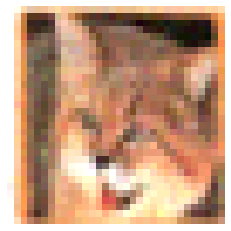

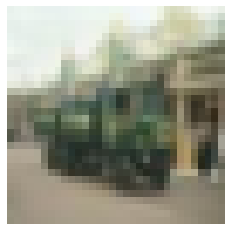

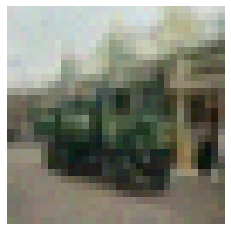

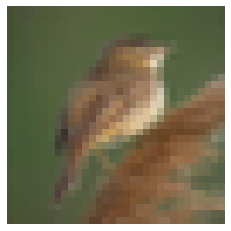

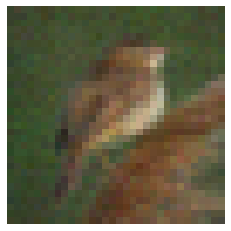

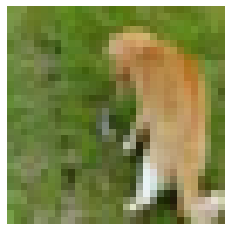

2021-05-10 12:16:24,426:[WARNING][image.py][set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


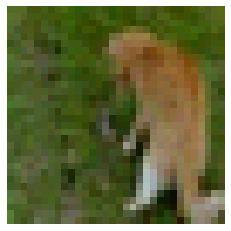

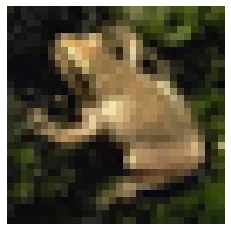

2021-05-10 12:16:24,564:[WARNING][image.py][set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


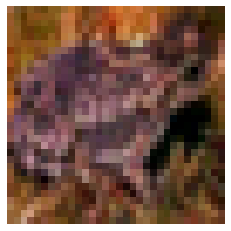

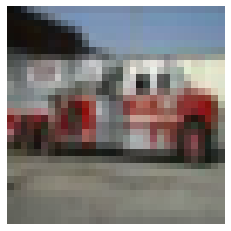

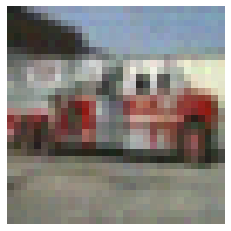

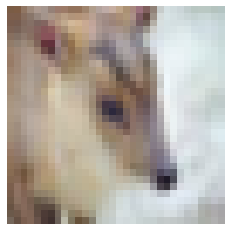

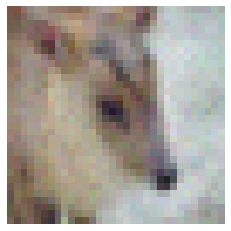

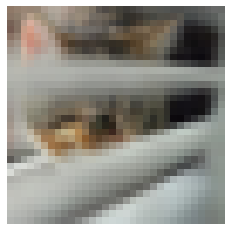

2021-05-10 12:16:24,974:[WARNING][image.py][set_data] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


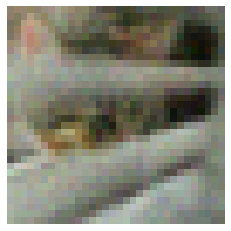

In [15]:
for i, r in zip(images, output):
    show_single_img(i)
    show_single_img(r)